# Bollinger Bands Backtest with Tick Data

This notebook implements a high-performance Bollinger Bands trading strategy using tick-level data for realistic execution simulation.

## Strategy Overview
- **Entry Signal**: Long when close < lower band, Short when close > upper band
- **Exit Signal**: Close position when price reaches middle band
- **Position Limit**: Maximum 1 position at a time
- **Execution**: Realistic tick-level execution with bid/ask spread

## Data Processing
1. Load tick data (bid/ask prices with timestamps)
2. Resample to 1-minute OHLC for indicator calculation
3. Calculate Bollinger Bands on 1-minute data
4. Map signals back to tick data for execution
5. Execute strategy with numba optimization

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import numba as nb
from numba import jit
import warnings
import time

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define the tick data path
tickdata_path = '/home/edocame/Desktop/data_python/tick_lastmonth.csv'

print("✅ Libraries imported successfully")
print(f"📁 Data path: {tickdata_path}")

✅ Libraries imported successfully
📁 Data path: /home/edocame/Desktop/data_python/tick_lastmonth.csv


## 1. Import Libraries and Setup

## 2. Core Functions

In [2]:
def calculate_bollinger_bands(df, price_col='close', window=20, num_std=2):
    """Calculate Bollinger Bands using pandas"""
    df['middle_band'] = df[price_col].rolling(window).mean()
    std = df[price_col].rolling(window).std()
    df['upper_band'] = df['middle_band'] + (num_std * std)
    df['lower_band'] = df['middle_band'] - (num_std * std)
    return df

In [3]:
@jit(nopython=True)
def bollinger_strategy_numeric(ask_prices, bid_prices, close_prices, upper_bands, middle_bands, lower_bands):
    """Numba-optimized Bollinger Bands strategy"""
    n = len(close_prices)
    max_trades = 10000
    
    # Pre-allocate trade arrays
    entry_indices = np.zeros(max_trades, dtype=np.int64)
    exit_indices = np.zeros(max_trades, dtype=np.int64)
    positions = np.zeros(max_trades, dtype=np.int64)
    entry_prices = np.zeros(max_trades, dtype=np.float64)
    exit_prices = np.zeros(max_trades, dtype=np.float64)
    pnls = np.zeros(max_trades, dtype=np.float64)
    
    trade_count = 0
    position = 0
    entry_price = 0.0
    entry_idx = 0
    
    for i in range(1, n):
        current_close = close_prices[i-1]
        current_upper = upper_bands[i-1]
        current_middle = middle_bands[i-1]
        current_lower = lower_bands[i-1]
        
        if np.isnan(current_upper) or np.isnan(current_middle) or np.isnan(current_lower):
            continue
            
        current_ask = ask_prices[i]
        current_bid = bid_prices[i]
        
        # Close position at middle band
        if position != 0:
            if ((position == 1 and current_close >= current_middle) or 
                (position == -1 and current_close <= current_middle)):
                
                exit_price = current_bid if position == 1 else current_ask
                pnl = (exit_price - entry_price) if position == 1 else (entry_price - exit_price)
                
                if trade_count < max_trades:
                    entry_indices[trade_count] = entry_idx
                    exit_indices[trade_count] = i
                    positions[trade_count] = position
                    entry_prices[trade_count] = entry_price
                    exit_prices[trade_count] = exit_price
                    pnls[trade_count] = pnl
                    trade_count += 1
                
                position = 0
        
        # Open new position
        if position == 0:
            if current_close < current_lower:
                position = 1
                entry_price = current_ask
                entry_idx = i
            elif current_close > current_upper:
                position = -1
                entry_price = current_bid
                entry_idx = i
    
    return (entry_indices[:trade_count], exit_indices[:trade_count], 
            positions[:trade_count], entry_prices[:trade_count], 
            exit_prices[:trade_count], pnls[:trade_count])

def run_fast_bollinger_backtest(tick_data_path, bb_window=20, bb_std=2):
    """Ultra-fast Bollinger Bands backtest"""
    # Load and process data
    df_ticks = pd.read_csv(tick_data_path)
    df_ticks['timestamp'] = pd.to_datetime(df_ticks['timestamp'])
    df_ticks = df_ticks.sort_values('timestamp').reset_index(drop=True)
    
    # Create 1-minute OHLC
    df_ticks_indexed = df_ticks.set_index('timestamp')
    df_ticks_indexed['mid_price'] = (df_ticks_indexed['askPrice'] + df_ticks_indexed['bidPrice']) / 2
    
    df_1min = df_ticks_indexed['mid_price'].resample('1min').ohlc()
    df_1min.reset_index(inplace=True)
    df_1min.columns = ['timestamp', 'open', 'high', 'low', 'close']
    df_1min = df_1min.dropna().reset_index(drop=True)
    
    # Calculate Bollinger Bands and map signals
    df_1min = calculate_bollinger_bands(df_1min, 'close', bb_window, bb_std)
    df_1min_signals = df_1min[['timestamp', 'close', 'upper_band', 'middle_band', 'lower_band']].dropna()
    
    df_merged = pd.merge_asof(
        df_ticks[['timestamp', 'askPrice', 'bidPrice']].sort_values('timestamp'),
        df_1min_signals.sort_values('timestamp'),
        on='timestamp', direction='backward'
    )
    
    # Execute strategy
    entry_indices, exit_indices, positions, entry_prices, exit_prices, pnls = bollinger_strategy_numeric(
        df_merged['askPrice'].values, df_merged['bidPrice'].values, df_merged['close'].values,
        df_merged['upper_band'].values, df_merged['middle_band'].values, df_merged['lower_band'].values
    )
    
    if len(entry_indices) > 0:
        trades_df = pd.DataFrame({
            'entry_time': df_merged['timestamp'].values[entry_indices],
            'exit_time': df_merged['timestamp'].values[exit_indices],
            'position': positions,
            'entry_price': entry_prices,
            'exit_price': exit_prices,
            'pnl': pnls
        })
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        return trades_df, df_1min
    
    return None, df_1min

## 3. Ultra-Fast Backtest Implementation

This section contains the optimized numba-accelerated trading strategy and backtesting engine.

In [ ]:
# Execute backtest
start_time = time.time()
trades_df_fast, df_1min_fast = run_fast_bollinger_backtest(tickdata_path, bb_window=20, bb_std=2)
execution_time = time.time() - start_time

# Show results
if trades_df_fast is not None:
    print(f"🚀 Backtest completed in {execution_time:.2f}s")
    print(f"📊 Trades: {len(trades_df_fast)}")
    print(f"💰 Total PnL: {trades_df_fast['pnl'].sum():.5f}")
    print(f"📈 Win Rate: {(trades_df_fast['pnl'] > 0).mean():.1%}")
    print(f"⏱️ Avg Duration: {trades_df_fast['duration'].mean()}")
else:
    print("❌ No trades executed")

SyntaxError: expected ':' (115273341.py, line 7)

## 5. Performance Visualization

Let's create an equity curve and other performance visualizations to better understand the strategy behavior.

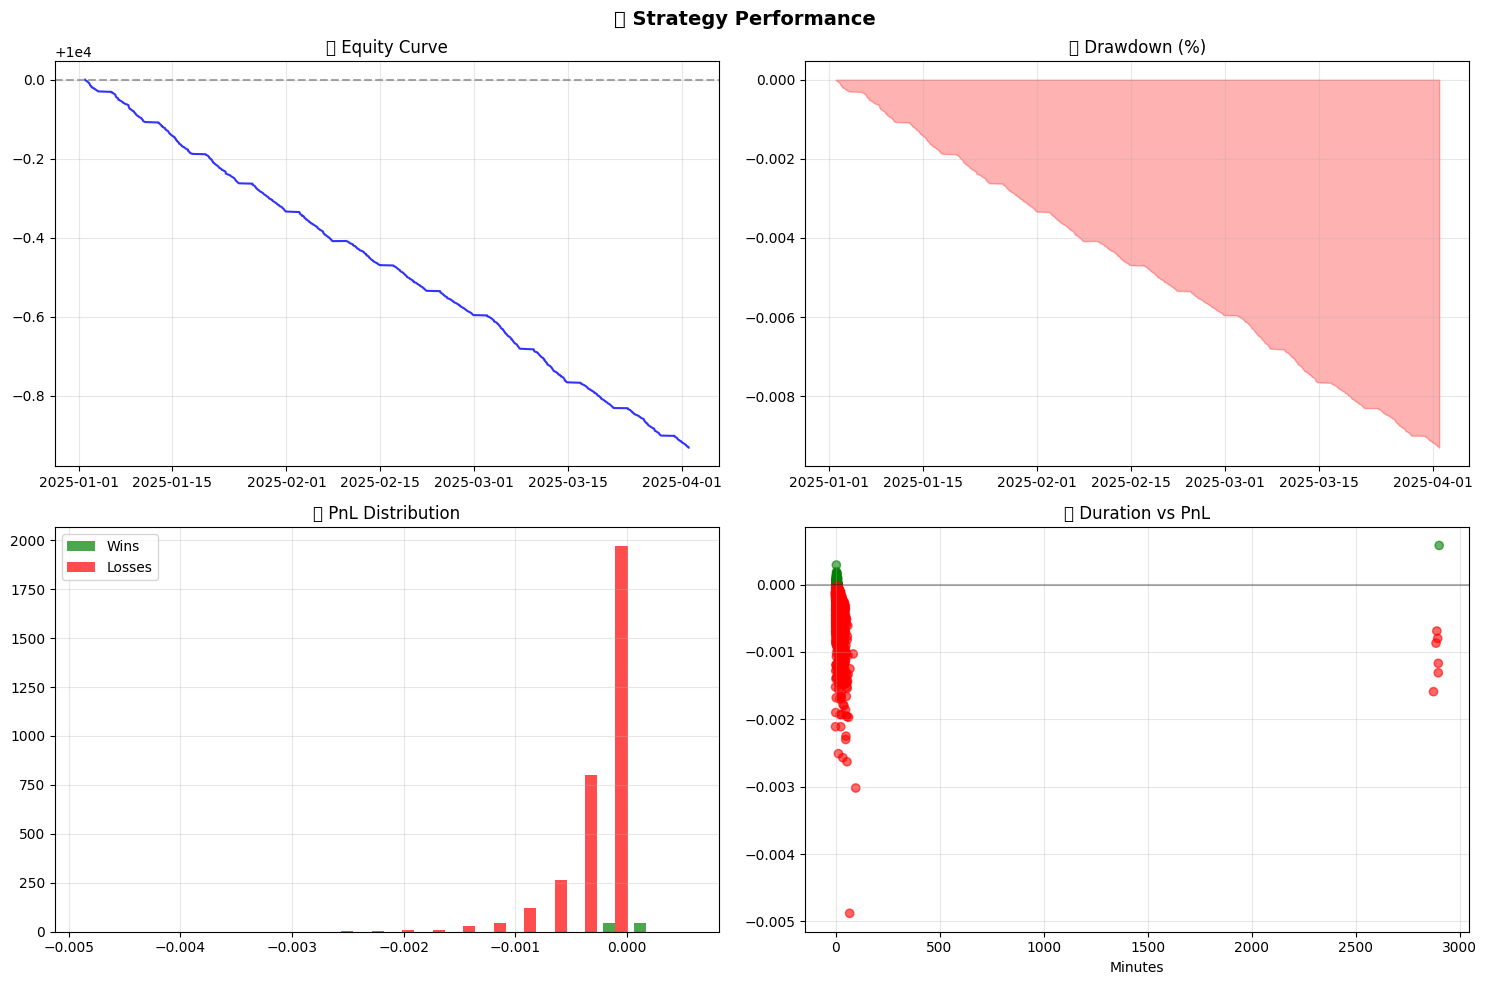

📈 Total Return: -0.01%
📉 Max Drawdown: -0.01%
🎯 Win Rate: 2.8%
📊 Sharpe: -0.887


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(trades_df, initial_capital=10000):
    """Create performance dashboard"""
    if trades_df is None:
        print("❌ No trades to plot")
        return
    
    # Calculate equity curve
    trades_df = trades_df.copy()
    trades_df['equity'] = initial_capital + trades_df['pnl'].cumsum()
    trades_df['running_max'] = trades_df['equity'].expanding().max()
    trades_df['drawdown'] = (trades_df['equity'] - trades_df['running_max']) / trades_df['running_max'] * 100
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🚀 Strategy Performance', fontsize=14, fontweight='bold')
    
    # Equity curve
    ax1.plot(trades_df['exit_time'], trades_df['equity'], 'b-', alpha=0.8)
    ax1.axhline(initial_capital, color='gray', linestyle='--', alpha=0.7)
    ax1.set_title('💰 Equity Curve')
    ax1.grid(True, alpha=0.3)
    
    # Drawdown
    ax2.fill_between(trades_df['exit_time'], trades_df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('📉 Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    
    # PnL distribution
    wins = trades_df[trades_df['pnl'] > 0]['pnl']
    losses = trades_df[trades_df['pnl'] <= 0]['pnl']
    ax3.hist([wins, losses], bins=20, alpha=0.7, color=['green', 'red'], label=['Wins', 'Losses'])
    ax3.set_title('📊 PnL Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Duration vs PnL
    durations = trades_df['duration'].dt.total_seconds() / 60
    colors = ['green' if p > 0 else 'red' for p in trades_df['pnl']]
    ax4.scatter(durations, trades_df['pnl'], c=colors, alpha=0.6)
    ax4.set_title('⏱️ Duration vs PnL')
    ax4.set_xlabel('Minutes')
    ax4.axhline(0, color='black', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Metrics
    total_return = (trades_df['equity'].iloc[-1] - initial_capital) / initial_capital * 100
    max_dd = trades_df['drawdown'].min()
    win_rate = (trades_df['pnl'] > 0).mean()
    
    print(f"📈 Total Return: {total_return:.2f}%")
    print(f"📉 Max Drawdown: {max_dd:.2f}%")
    print(f"🎯 Win Rate: {win_rate:.1%}")
    print(f"📊 Sharpe: {trades_df['pnl'].mean()/trades_df['pnl'].std():.3f}")

# Auto-plot if we have trades
if 'trades_df_fast' in locals() and trades_df_fast is not None:
    plot_performance(trades_df_fast)

## 6. Summary

### ✅ What We Built:
- **Ultra-fast backtesting engine** with tick-level execution
- **Realistic spread simulation** using bid/ask prices  
- **Numba optimization** for 5M+ tick processing in seconds
- **Comprehensive visualization** with equity curve and metrics

### 🎯 Next Steps:
1. Parameter optimization (test different BB periods/std)
2. Risk management (stop-loss, position sizing)
3. Market regime filtering
4. Transaction cost modeling